#Mounting & Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling
from tensorflow.keras.callbacks import EarlyStopping
import shutil
from tensorflow.keras.models import load_model, Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt
from keras import applications

In [3]:
!pip install -q --upgrade wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 180 kB 8.8 MB/s 
     |████████████████████████████████| 97 kB 6.0 MB/s 
     |████████████████████████████████| 133 kB 43.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./03. Utils')
import MyFunctions

#The Model

https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
https://github.com/priya-dwivedi/Deep-Learning/tree/master/resnet_keras

In [4]:
IMAGE_SIZE = (128,128)
NUM_CLASSES = 3 
BATCH_SIZE = 32 

In [5]:
df_train=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train0-7.xlsx")
df_test=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test0-7.xlsx")

In [6]:
train_datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255)
dir = '/content/drive/My Drive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
train_batches = train_datagen.flow_from_dataframe( #tomamos info de un df
    df_train, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 13951 validated image filenames belonging to 3 classes.


In [7]:
valid_batches = train_datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='ImageID',y_col='Projection',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 3487 validated image filenames belonging to 3 classes.


In [8]:
from tensorflow.keras.applications import resnet50
base_model = resnet50.ResNet50(weights= None, include_top=False, input_shape= (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False 
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten()) 
model.add(layers.Dense(256, activation="relu")) 
model.add(layers.Dense(NUM_CLASSES, activation="softmax")) 
x = model.output

In [9]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 31,977,347
Trainable params: 8,389,635
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
# Initialize wandb with your project name
run = wandb.init(project='filter',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 100,
                     "batch_size": 32,
                     "Transfer Learning":"No",
                     "loss_function": "categorical_crossentropy",
                     "architecture": "ResNet 50",
                     "dataset": "PA-AP-L"
                 })
config = wandb.config

wandb: Currently logged in as: eberrino (use `wandb login --relogin` to force relogin)


In [12]:
history = model.fit(train_batches, validation_data = valid_batches , epochs = 100,workers=10,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),WandbCallback()], batch_size = BATCH_SIZE)

Epoch 1/100
436/436 [==============================] - 468s 980ms/step - loss: 0.2682 - accuracy: 0.9176 - val_loss: 0.1709 - val_accuracy: 0.9467


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
436/436 [==============================] - 123s 279ms/step - loss: 0.1569 - accuracy: 0.9485 - val_loss: 0.1294 - val_accuracy: 0.9613
Epoch 3/100
436/436 [==============================] - 119s 268ms/step - loss: 0.1367 - accuracy: 0.9574 - val_loss: 0.1140 - val_accuracy: 0.9667
Epoch 4/100
436/436 [==============================] - 115s 260ms/step - loss: 0.1220 - accuracy: 0.9628 - val_loss: 0.1033 - val_accuracy: 0.9667
Epoch 5/100
436/436 [==============================] - 116s 262ms/step - loss: 0.1124 - accuracy: 0.9661 - val_loss: 0.0993 - val_accuracy: 0.9690
Epoch 6/100
436/436 [==============================] - 115s 259ms/step - loss: 0.1071 - accuracy: 0.9696 - val_loss: 0.1007 - val_accuracy: 0.9728
Epoch 7/100
436/436 [==============================] - 114s 254ms/step - loss: 0.0986 - accuracy: 0.9720 - val_loss: 0.0933 - val_accuracy: 0.9685
Epoch 8/100
436/436 [==============================] - 117s 265ms/step - loss: 0.0968 - accuracy: 0.9716 - val_loss: 0

In [13]:
model.save('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Exp 2: Mejoras a la Clasificaciónde proyecciones/ResNet_NoTL.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


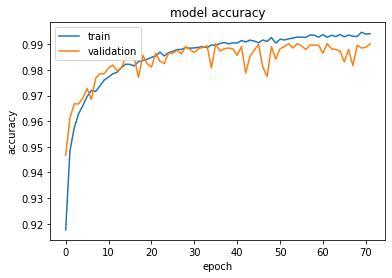

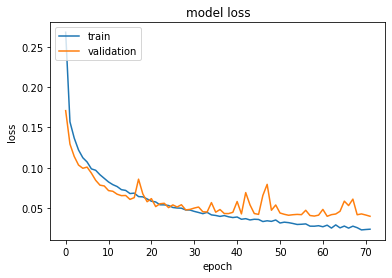

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical"#, validate_filenames=False
    )

Found 4360 validated image filenames belonging to 3 classes.


In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Exp 2: Mejoras a la Clasificaciónde proyecciones/ResNet_NoTL.h5')

In [16]:
#Calculamos la matriz de predicciones
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)

4360/4360 [==============================] - 1015s 232ms/step
(4360, 3)


In [ ]:
#Calculamos la matriz de predicciones
#result_test=model.predict(test_batches, verbose=1)
print ("Loss = " + str(result_test[0]))
print ("Test Accuracy = " + str(result_test[1]))

Loss = [0.0024932  0.00563455 0.99187225]
Test Accuracy = [3.4253206e-12 6.0411563e-15 1.0000000e+00]


In [17]:
#Obtenemos el nombre de clase asociado a cada indice
classes_dict = dict(zip(train_batches.class_indices.values(),train_batches.class_indices.keys()))
classes_dict

{0: 'AP_horizontal', 1: 'L', 2: 'PA'}

In [18]:
import os 
os.chdir('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./03. Utils/')
import MyFunctions

In [19]:
preds_classes, gts = MyFunctions.after_test(classes_dict,result_test,test_batches)

PA               2698
L                1444
AP_horizontal     218
dtype: int64
               precision    recall  f1-score   support

AP_horizontal       0.95      0.95      0.95       217
            L       0.99      1.00      0.99      1427
           PA       1.00      0.99      0.99      2716

     accuracy                           0.99      4360
    macro avg       0.98      0.98      0.98      4360
 weighted avg       0.99      0.99      0.99      4360



In [ ]:
#Obtenemos el índice de mayor score en cada fila (cada imagen)
preds = result_test.argmax(axis=-1)

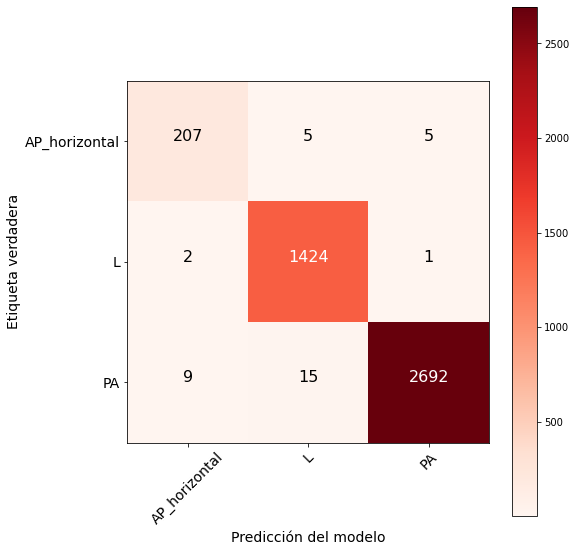

In [20]:
MyFunctions.plot_confusion_matrix(gts,preds_classes,test_batches.class_indices.keys(),
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/NoTL/Images/CM')

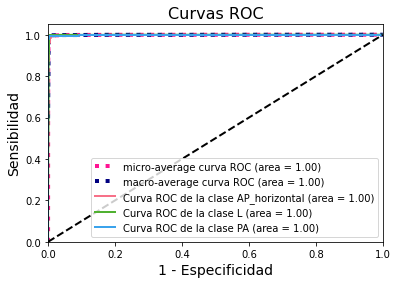

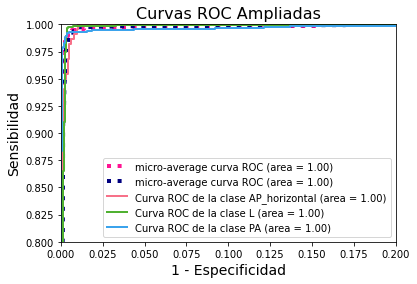

In [21]:
MyFunctions.plot_ROC(result_test,gts,NUM_CLASSES, classes_dict,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/NoTL/Images/ROC_Filtro_Unico')

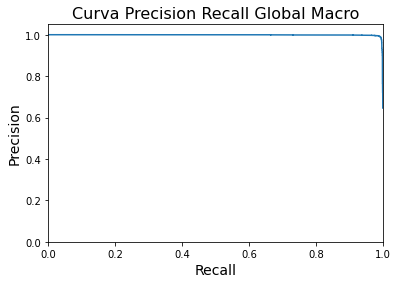

In [22]:
MyFunctions.precision_recall_global(result_test,gts,NUM_CLASSES,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/NoTL/Images/PRG_Filtro_Unico')

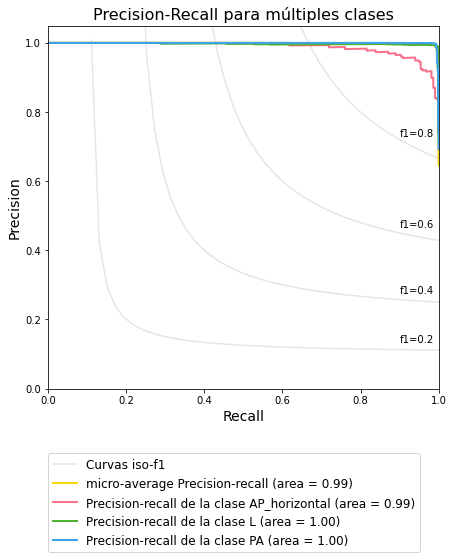

In [23]:
MyFunctions.precision_recall_many(result_test,gts,NUM_CLASSES, classes_dict,
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/NoTL/Images/PRM_Filtro_Unico')

In [24]:
pd.DataFrame(result_test).to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/NoTL/result_test_crude.csv')

In [25]:
df_test["Pred"] = preds_classes

In [26]:
df_test["result"] = df_test["Projection"]==df_test["Pred"]
df_test.head()

,Unnamed: 0,ImageID,ImageDir,Projection,Pred,result
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA,True
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA,True
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA,True
3,3,1/213096160366986458367121958911602047465_wble...,1,PA,PA,True
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA,True


In [27]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/02. ResNet-50/Results/NoTL/result_test_final.csv')